# Analyzing Trends in News Headlines
---

## Introduction
---

Whenever I opened a homepage of a news website, I was greeted with at least five most recent news headlines. Usually, four out of five or even all the headlines carried a negative message, "a plain crashed", "new virus was found", "there is a nuclear threat", "a terrorist group has done something", etc. While I opened the homepage with a good mood, after reading a few negative headlines, my mood would instantlry change and I would get depressed, because so many bad things are happening to our society.

There were many posts written about why the headlines are dominated with negative news, some say it is, because the news come from all over the world, and that is why it seems that only negative things are happening around us, even though nothing bad happened in their your city. Another, very interesting reason, is that people make naive decisions while they are depressed. Busineses can benefit from this, because while people are depressed they are more scared to lose their job, and since everyone is in constant stress the sales in the entertainment industry have been on the rise. Finacial institutions can also benefit from this, since people are depressed they make unwise decisions and sell their investments (house, car, stacks, etc.) at low cost.

I have decided to check if the news publishers try to manipulate people using the top news headlines (since that's what most people see most of the time). For this I used three news publishers that were best known to me, they were Russia Today (RT), The Washington Times (WT), and The Canadian Broadcasting Corporation (CBC). I decided to collect and analyze political news headlines of theses news publishers.

To try to support some of the assumptions about negative news headlines, for example "... since everyone is in constant stress the sales ... have been on the rise", I have decided to analyze the changes in the number of negative headlines produced by CBC during the The Calgary Stampede festival. I also wanted to find any patterns in negative news headlines being posted in general, for example, if there are always less negative headlines on Tuesdays, or if there are always more negative headlines on the first day of the month, etc.

While collecting news headlines, I have noticed that in many of the headlines the names, such as Trump, Putin, and Trudeau came up very often, I have decided to collect this data and in the end, see who is the most "famous" president/prime minister. Also, a lot of the headlines had country names in them, I have decided to collect this data as well, and later see, which country makes it into the news most often.

## Collecting Data
---

### Data Sources

For my sources I decided to scrape websites of three news publishers for approximently one month of time. I scraped the homepage of [RT](https://www.rt.com/), the politics page of [The Washington Times](http://www.washingtontimes.com/news/politics/), and the politics page of [CBC News](http://www.cbc.ca/news/politics).

To scrape the websites, I made a Python script `scraper.py`, the script collected news headlines at different times throughout the day. The script would scrape all three websites in the morning at 11:00AM, then during the day at 14:00PM. and finally in the evening at 18:00PM. 

The reason for using three different news publishers and scheduling the script to scrape at differnt times throughout the day was, because I was trying to get as much variation as possible, to help me find as many insights from the data.

### Automating Work

To save my self the time and headache of remembering to scrape the websites at certain times, I spun a simple Ubuntu droplet on DigitalOcean. I used the [Python Schedule package](https://pypi.python.org/pypi/schedule) to automate the script to run at specific times throughout the day.

To run the script as a background process I used the following command `nohup python3 scraper.py > scraper.out 2>scraper.err &`.


### Watson API

To analyze the news headlines I used IBM's Watson [Natural Language Understanding](https://natural-language-understanding-demo.mybluemix.net/) (NLU) API. NLU is a collection of different APIs that analyze text to help understand its concepts, entities, keywords, sentiment, and more.

For every news headline, I requested the sentiment analysis, emotions, and entities to be returned by the NLU API.

* Sentiment Analysis - provided a label for every headline, either negative, positive, or neutral, and score, between -1 and 1.
* Emotions - provided individual scores for each of the following, joy, anger, disgust, sadness, and fear. Each score was between 0 and 1, such that sum(joy score, anger score, disgust score, sadness score, and fear score) is always 1.
* Entities - identified people, companies, countries, etc.

### Scraper Script

The following is a chunk from `scraper.py` script, the chunk was used to scrape, analyse, and then write the information (news headlines and their analysis) to a `.txt` file from the RT homepage. Similarly structured code was used to scrape and save the analysis for headlines from the other two publishers.

```python
    ...

    with open(filename, mode) as fp:

        # Start of Russia Today news
        fp.write('N RT\n')

        # Scrapes the website of Russia Today news network and writes news headlines to a file
        for ul_tag in soup.find_all('ul', {'class': 'main-promobox__list'}):
            for li_tag in ul_tag.find_all('li', {'class': 'main-promobox__item'}):
                for headline in li_tag.find_all('a', {'class': 'main-promobox__link'}):

                    news_headline = headline.text.lstrip().replace('\n', '')

                    fp.write('H ')
                    fp.write(news_headline)
                    fp.write('\n')
                    fp.write('J ')
                    json.dump(NLU.analyze(text=news_headline, features=[features.Sentiment(), 
                            features.Emotion(), features.Entities()]), fp)
                    fp.write('\n')
    ...
```

## Data Wrangling
---
    
### Storing/Saving Data

The following is a chunk from one of the `.txt` files containing information (news headlines and their analysis) from all three news publishers. It shows how the information was being stored after every time the websites was parsed.

The data shows the first two headlines from RT homepage.

* **N** indicates the start of a new news publisher
* **H** indicates a new headline
* **J** indicates the NLU analysis of the above headline

```sh
...

N RT

H ‘Putin wanted Hillary Clinton to win the election’ – Trump                                                                    
J {"language": "en", "entities": [{"relevance": 0.33, "count": 1, "text": "Hillary Clinton", "type": "Person", "disambiguation": {"dbpedia_resource": "http://dbpedia.org/resource/Hillary_Rodham_Clinton", "name": "Hillary Rodham Clinton", "subtype": ["Politician", "Appointee", "AwardWinner", "BoardMember", "Celebrity", "HallOfFameInductee", "OperaCharacter", "Senator", "U.S.Congressperson", "TVActor"]}}, {"relevance": 0.33, "count": 1, "text": "Trump", "type": "Company"}], "sentiment": {"document": {"label": "neutral", "score": 0.0}}, "emotion": {"document": {"emotion": {"anger": 0.179606, "disgust": 0.139299, "sadness": 0.270869, "joy": 0.256665, "fear": 0.082043}}}}

H Berlin to boost aviation safety amid fears hackers can hijack warplanes                                                                    
J {"language": "en", "entities": [{"relevance": 0.33, "count": 1, "text": "Berlin", "type": "Location", "disambiguation": {"subtype": ["City"]}}], "sentiment": {"document": {"label": "neutral", "score": 0.0}}, "emotion": {"document": {"emotion": {"anger": 0.020501, "disgust": 0.034013, "sadness": 0.011869, "joy": 0.021755, "fear": 0.755602}}}}

...
```

### JSON to CSV

To be able to work with the collected information using the Python `pandas` module, I had to convert it into a `pandas` readable format, such as CSV. The following shows the parsed version of the above chuck from the `.txt` file in a CSV format.

In [13]:
import pandas as pd

# Read data into a dataframe
example = pd.read_csv('JSON-to-CSV-Example.csv')

# Remove the ID column
example = sample.iloc[:, 1:]

# Show the first 2 rows of the dataframe
example.head(2)

,TIME,TIME_OF_DAY,NETWORK,HEADLINE,SENTIMENT_LABEL,SENTIMENT_SCORE,EMOTION_SADNESS,EMOTION_FEAR,EMOTION_ANGER,EMOTION_DISGUST,EMOTION_JOY,PUTIN,TRUMP,TRUDEAU
0,11:00:01,Morning,RT,"‘She bled to death, nobody paid attention’: IS...",neutral,0.000000,0.142958,0.088965,0.095943,0.436215,0.337410,0,0,0
1,11:00:01,Morning,RT,‘Mistreatment of anybody is never justified’: ...,negative,-0.868277,0.171880,0.200708,0.371097,0.557458,0.003115,0,0,0


### Missing Values

Sometimes the Watson IBM interpreted the headline as being written in languages other than English, for example French, because of this the `Emotion` property was missing from the analysis.

```sh

H Montreal nixes sovereignist group's plan to mark Charles de Gaulle's 'Vive le Quebec libre!' speech

J {"warnings": ["emotion: unsupported text language: fr"], "language": "fr", "entities": [{"relevance": 0.978347, "count": 1, "text": "Charles de Gaulle", "type": "Person"}], "sentiment": {"document": {"label": "positive", "score": 0.688072}}}

```

### Country Presidents

To pick the country names and president names from each headline, I requested the `Entities` property to be returned by the Watson API, the API did a good job in doing so, but sometimes the API would make a mistake. For the following headline the Watson API did not recognize `Putin` to be a president or a person of any type, and it recognized `Trump` to be a company and not a person of type president.

```sh

H ‘Putin wanted Hillary Clinton to win the election’ – Trump                                                                    
J {"language": "en", "entities": [{"relevance": 0.33, "count": 1, "text": "Hillary Clinton", "type": "Person", "disambiguation": {"dbpedia_resource": "http://dbpedia.org/resource/Hillary_Rodham_Clinton", "name": "Hillary Rodham Clinton", "subtype": ["Politician", "Appointee", "AwardWinner", "BoardMember", "Celebrity", "HallOfFameInductee", "OperaCharacter", "Senator", "U.S.Congressperson", "TVActor"]}}, {"relevance": 0.33, "count": 1, "text": "Trump", "type": "Company"}], "sentiment": {"document": {"label": "neutral", "score": 0.0}}, "emotion": {"document": {"emotion": {"anger": 0.179606, "disgust": 0.139299, "sadness": 0.270869, "joy": 0.256665, "fear": 0.082043}}}}

```

Since, I wanted to avoid these types of errors in the future, I decided to parse the news headline for presidents names instead of the `Entities` property. This worked well, because I was only interested in three presidents/prime ministers `Trump`, `Trudeau`, and `Putin`.

## Analyzing Data
---

In [121]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

# Read data into a dataframe
morning = pd.read_csv('Morning.csv')

# Remove the ID column
morning = morning.iloc[:, 1:]

# Read data into a dataframe
day = pd.read_csv('Day.csv')

# Remove the ID column
day = day.iloc[:, 1:]

# Read data into a dataframe
evening = pd.read_csv('Evening.csv')

# Remove the ID column
evening = evening.iloc[:, 1:]

# Combine `morning`, `day`, and `evening`
sample = pd.read_csv('Complete.csv')

# Remove the ID column
sample = sample.iloc[:, 1:]

### What is the Composition of all News Headlines ?

* Compare the quantity of Negative, Positive, and Neutral news headlines
* This needs to be done using all news headlines
* Pie Chart

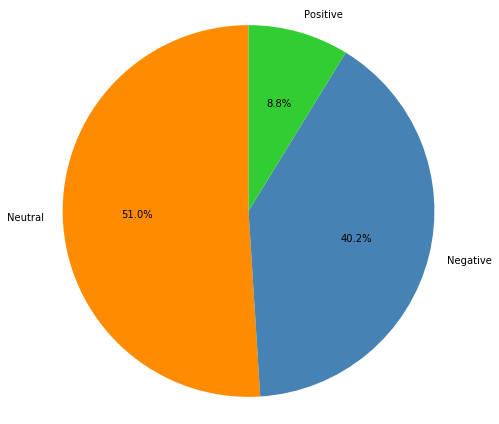

In [39]:
# Get the total number of Neutral, Negative, and Positive news headlines
count = sample['SENTIMENT_LABEL'].value_counts()

neutral = count[0]
negative = count[1]
positive = count[2]

# Define labels
labels = 'Neutral', 'Negative', 'Positive'

# Define the data
sizes = [neutral, negative, positive]

# Plot Pie Chart
fig1, ax1 = plt.subplots(figsize = (6, 6))

# Pie Chart settings
ax1.pie(sizes, 
        labels = labels, 
        autopct = '%1.1f%%', 
        startangle = 90, colors = ['darkorange', 'steelblue', 'limegreen'])

# Makes the Pie Chart round
ax1.axis('equal')

# Plot settings
plt.tight_layout()

plt.show()

#### Interpretation of the Plot

Besides only having negative or positive headlines, the sentiment analysis of the Watson API categorized every headline to be either negative, neutral, or positive.

Surprisingly, it turned out that it's not the negative news that dominate the headlines. Neutral was the dominant category, while positive headlines were in the minority.

### On What Days of the Week are There More Negative, Positive, and/or Neutral News Headlines ?

* How does **day/date** effect the  quantity of Negative and Positive news

    * Trying to find patterns
        * If the number of negative news repeats every week
    * This needs to be done using all news headlines
    * Group news by Date 
    * Count the number of Negative and Positive news in each group
    * Use Line Chart to compare Negative and Positive news over time
    * Two lines, one for Negative and one for Positive

* Trying to find patterns
    * If the number of negative news repeats every week
* This needs to be done using all news headlines
* Group news by Date 
* Count the number of Negative and Positive news in each group
    * Count the number of Negative and Positive news in each day
* Use Line Chart to compare Negative and Positive news over time
* Two lines, one for Negative and one for Positive

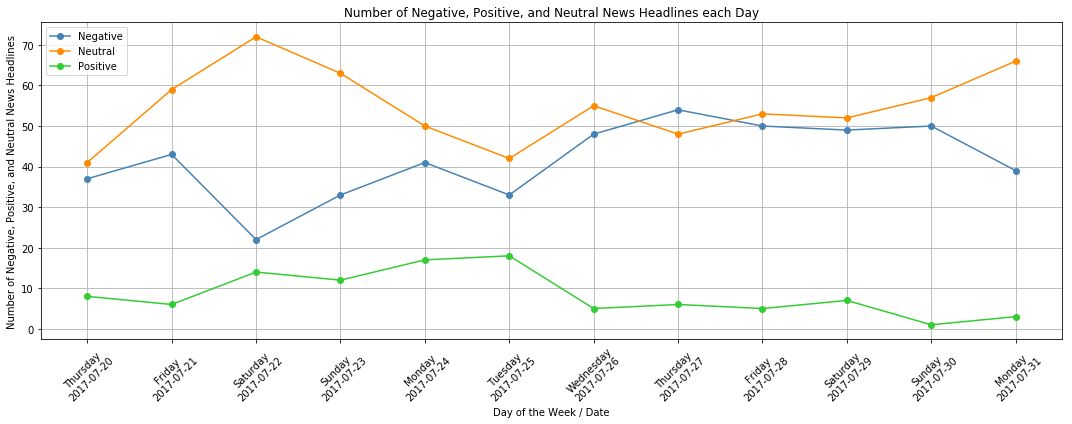

In [45]:
# Only analyze news from 2017-07-20 to 2017-07-31, to make the analysis unbiased
limited_sample = pd.concat([morning, day, evening])

# Create emotions array, used when accessing `date_grouped` series
emotions = ['negative', 'neutral', 'positive']

# Get a list of all dates from the DATE column, ['2017-07-12', '2017-07-13', ...]
dates = list(limited_sample.groupby('DATE').groups.keys())
dates = sorted(dates)

# Get a list of days of the week from the `dates` list, ['Wednesday', 'Thursday', ...]
dates_df = pd.DataFrame(dates)
days_of_week = pd.to_datetime(dates_df[0]).dt.weekday_name
days_of_week = list(days_of_week)

# Create a list, which contains combinations of `dates` and `days_of_week`
days_of_week_dates = []

# Fill the `days_of_week_dates` list
for day, date in zip(days_of_week, dates):
    temp = day + '\n' + date
    days_of_week_dates.append(temp)

# Group rows by DATE
# In each group count the number of Negative, Neutral, and Positive news
# This will include news from morning, day, and evening
date_grouped = limited_sample.groupby('DATE').SENTIMENT_LABEL.value_counts()

# Keep track of the number of days
days_counter = 1
days_counter_list = []

# Keep track of the number of Negative, Neutral, and Positive news in each day
negative = []
neutral = []
positive = []

# Fill the `negative`, `neutral`, `positive`, and `days_counter_list` lists
for date in dates:
    for emotion in emotions:
        
        # We access the date_grouped series as follows
        # date_grouped['2017-07-12']['negative'] = number of negative news on 2017-07-12
        
        if emotion == 'negative':
            
            days_counter_list.append(days_counter)
            days_counter += 1
            
            try:
                negative.append(date_grouped[date][emotion])
            except:
                negative.append(0)
        
        if emotion == 'neutral':
            
            try:
                neutral.append(date_grouped[date][emotion])
            except:
                neutral.append(0)
        
        if emotion == 'positive':
            
            try:
                positive.append(date_grouped[date][emotion])
            except:
                positive.append(0)

# Plot Line Chart
fig1, ax1 = plt.subplots(figsize = (15, 6))

# Define lines
ax1.plot(days_counter_list, negative, marker='o', zorder = 3, label = 'Negative', color = 'steelblue')
ax1.plot(days_counter_list, neutral, marker='o', zorder = 3, label = 'Neutral', color = 'darkorange')
ax1.plot(days_counter_list, positive, marker='o', zorder = 3, label = 'Positive', color = 'limegreen')

# Define labels
plt.title('Number of Negative, Positive, and Neutral News Headlines each Day')
plt.xlabel('Day of the Week / Date')
plt.ylabel('Number of Negative, Positive, and Neutral News Headlines')

# Define x and y-axis ticks
plt.xticks(days_counter_list, days_of_week_dates, rotation = 45)

# Plot settings
plt.grid(zorder = 0)
plt.legend()
plt.tight_layout()

plt.show()

#### Interpretation of the Plot


### Are There More Negative, Positive, and/or Neutral News Headlines in the Morning, Day, and/or Evening?

* How does **time of day** effect the quantity of Negative and Positive news

    * This needs to be done using all news headlines
    * Group news by Time_of_Day 
    * Count the number of Negative and Positive news in each group
    * Use Column Chart to compare Negative and Positive in the morning, day, and evening
    * Three columns, one for morning, one for day, and one for evening



* This needs to be done using all news headlines
* Group news by Time_of_Day 
* Count the number of Negative and Positive news in each group
    * Count the number of Negative and Positive news in the morningn day, and evening
* Use Column Chart to compare Negative and Positive in the morning, day, and evening
* Three columns, one for morning, one for day, and one for evening

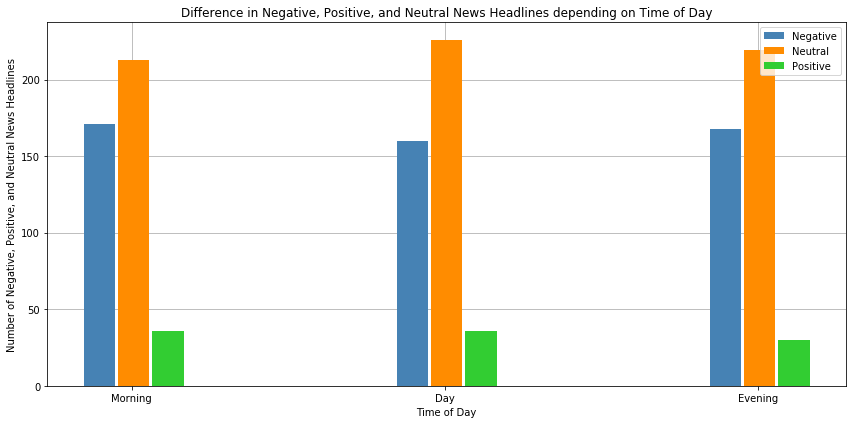

In [147]:
# Get the total number of Neutral, Negative, and Positive news headlines in the morning
morning_count = morning['SENTIMENT_LABEL'].value_counts()

# Get the total number of Neutral, Negative, and Positive news headlines during the day
day_count = day['SENTIMENT_LABEL'].value_counts()

# Get the total number of Neutral, Negative, and Positive news headlines during the day
evening_count = evening['SENTIMENT_LABEL'].value_counts()

# Define labels list
labels = ['Morning', 'Day', 'Evening']

# Plot Bar Chart
fig1, ax1 = plt.subplots(figsize = (12, 6))

# Bar Chart settings
ax1.bar([0, 1, 2], [morning_count['negative'], day_count['negative'], evening_count['negative']], zorder = 3, width = 0.1, color = 'steelblue', label = 'Negative')
ax1.bar([(x + 0.11) for x in [0, 1, 2]], [morning_count['neutral'], day_count['neutral'], evening_count['neutral']], zorder = 3, width = 0.1, color = 'darkorange', label = 'Neutral')
ax1.bar([(x + 0.22) for x in [0, 1, 2]], [morning_count['positive'], day_count['positive'], evening_count['positive']], zorder = 3, width = 0.1, color = 'limegreen', label = 'Positive')

# print(morning_count['negative'], day_count['negative'], evening_count['negative'])
# print(morning_count['neutral'], day_count['neutral'], evening_count['neutral'])
# print(morning_count['positive'], day_count['positive'], evening_count['positive'])

# Define labels
plt.title('Difference in Negative, Positive, and Neutral News Headlines depending on Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Number of Negative, Positive, and Neutral News Headlines')

# Define the tricks on the x-axis to be the country names
plt.xticks([(x + 0.104) for x in [0, 1, 2]], labels)

# Plot settings
plt.tight_layout()
plt.legend()
plt.grid(zorder = 0)

plt.show()

#### Interpretation of the Plot

For this analysis, I wanted to find out, which time of day has more/less negative, neutral, and positive news headlines. Turns out that while neutral headlines lines dominate in the morning, day, and evening, there are more negative news in the morning, while there are less positive news in the evening.

### Do Big Celebrations Have an Effect on the Number of Negative, Positive, and Neutral News Headlines?

* How do big celebrations (Stampede) effect the quantity of Negative and Positive news

    * **Maybe they increased because they want people to be depressed and spend more money**

    * Did they increase or decrease over the course of that week
    * This needs to be done using all news headlines
    * Create a new dataframe, consisting only of CBC news
    * Group the new dataframe by Date and count the number of Negative and Positive news
    * Use Line Chart to compare Negative and Positive news over time
    * Only one line showing CBC news (would be nice to find a way to highlight the stampede week)
* Stampede start date: Friday, July 7
* Stampede end date: Sunday, July 16


* **Maybe they increased because they want people to be depressed and spend more money**


* Did they increase or decrease over the course of that week
* This needs to be done using all news headlines
* Create a new dataframe, consisting only of CBC news
* Group the new dataframe by Date and count the number of Negative and Positive news
* Use Line Chart to compare Negative and Positive news over time
* Only one line showing CBC news (would be nice to find a way to highlight the stampede week)

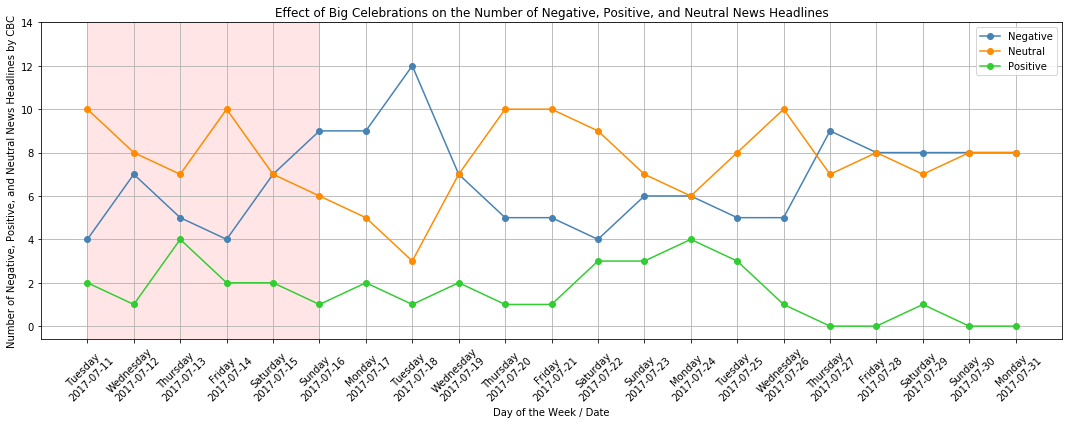

In [117]:
# Load Stampede data
stamp = pd.read_csv('Stampede.csv')

# Remove the ID column
stamp = stamp.iloc[:, 1:]

# Create emotions list, used when accessing `date_grouped` series
emotions = ['negative', 'neutral', 'positive']

# Get a list of all dates from the DATE column, ['2017-07-12', '2017-07-13', ...]
dates = list(stamp.groupby('DATE').groups.keys())
dates = sorted(dates)

# Get a list of days of the week from the `dates` list, ['Wednesday', 'Thursday', ...]
dates_df = pd.DataFrame(dates)
days_of_week = pd.to_datetime(dates_df[0]).dt.weekday_name
days_of_week = list(days_of_week)

# Create a list, which contains combinations of `dates` and `days_of_week`
days_of_week_dates = []

# Fill the `days_of_week_dates` list
for day, date in zip(days_of_week, dates):
    temp = day + '\n' + date
    days_of_week_dates.append(temp)

# Create a series of the number of negative, netural, and postiive news on each date
cbc_count = stamp.groupby(['DATE', 'NETWORK']).SENTIMENT_LABEL.value_counts()

# Keep track of the number of days
days_counter = 1
days_counter_list = []

# Keep track of the number of Negative, Neutral, and Positive news in each day
negative = []
neutral = []
positive = []

# Fill the `negative`, `neutral`, `positive`, and `days_counter_list` lists
for date in dates:
    for emotion in emotions:
        
        # We access the cbc_count series as follows
        # cbc_count['2017-07-12']['CBC']['negative'] = number of negative news from CBC publisher on 2017-07-12
        
        if emotion == 'negative':
            
            days_counter_list.append(days_counter)
            days_counter += 1
            
            try:
                negative.append(cbc_count[date]['CBC'][emotion])
            except:
                negative.append(0)
        
        if emotion == 'neutral':
            try:
                neutral.append(cbc_count[date]['CBC'][emotion])
            except:
                neutral.append(0)
        
        if emotion == 'positive':
            try:
                positive.append(cbc_count[date]['CBC'][emotion])
            except:
                positive.append(0)

# Plot Line Chart
fig1, ax1 = plt.subplots(figsize = (15, 6))

# Define lines
ax1.plot(days_counter_list, negative, marker='o', zorder = 3, label = 'Negative', color = 'steelblue')
ax1.plot(days_counter_list, neutral, marker='o', zorder = 3, label = 'Neutral', color = 'darkorange')
ax1.plot(days_counter_list, positive, marker='o', zorder = 3, label = 'Positive', color = 'limegreen')

# Define labels
plt.title('Effect of Big Celebrations on the Number of Negative, Positive, and Neutral News Headlines')
plt.xlabel('Day of the Week / Date')
plt.ylabel('Number of Negative, Positive, and Neutral News Headlines by CBC')

# Define x and y-axis ticks
plt.xticks(days_counter_list, days_of_week_dates, rotation = 45)
plt.yticks(np.arange(0, 16, 2))

# Plot settings
plt.grid(zorder = 0)
plt.axvspan(1, 6, color='red', alpha=0.1)
plt.legend()
plt.tight_layout()


plt.show()

#### Interpretation of the Plot

The above only uses news headlines from the CBC news publisher, since Stampede is a Canadian celebration, it would not make sence to include headlines from WT and RT.

Since the collection of data started on 2017-07-11, which was roughly the in middle of Stampede, I had limited data and every headline was helpful, hence I only used the Morning dataset, which had data from 2017-07-11 to 2017-07-31.

The red highlighted area indicates the days of Stamepede that were recorder (from 2017-07-11 to 2017-07-16). There doesn't seem to be any anomalies in the number of negative, neutral, and positive news headlines in the red area. However, the number of negative, neutral, and positive seems to be more stable, always staying between the count of 1 and 10, which is not true for other days.

My hypothesis of businesses increasing number of negative news to decrease the happiness in people, so the sales increase, was not supported.

### Which Emoition Dominates in the Morning, Day, and/or Evening?

* Compare the Emoitions (Joy, Anger, Saddness, etc...)

    * This needs to be done using all news headlines
    * Group news by Time_of_Day 
    * For every group (morning, day, evening)
        * Take the highest emotion from every headline (every row)
        * Then figure out which emotion dominates, higher the frequence --> more dominant
        * Plot a Histogram
    * Plot three Histogram, one for morning, one for day, and one for evening


* This needs to be done using all news headlines
* Group news by Time_of_Day 
* For every group (morning, day, evening)
    * Take the highest emotion from every headline (every row)
    * Then figure out which emotion dominates, higher the frequence --> more dominant
    * Plot a Bar Chart
* Plot three Bar Chart, one for morning, one for day, and one for evening

In [90]:
# # Define a list labels
# labels = ['Saddness', 'Fear', 'Anger', 'Disgust', 'Joy']

# # Define a list of ids, which is the size of the number of emotions
# ids = [0, 1, 2, 3, 4]

# # Create a dataframe of dominant emotion per date
# # x-axis is the date (2017-07-12 --> 0, 2017-07-13 --> 1, ...])
# # y-axis is time of day (Morning, Day, Evening)
# emotions_by_time_of_day = sample.groupby('TIME_OF_DAY')[['EMOTION_SADNESS', 
#                                                          'EMOTION_FEAR', 
#                                                          'EMOTION_ANGER', 
#                                                          'EMOTION_DISGUST', 
#                                                          'EMOTION_JOY']].idxmax(axis = 1, skipna = True)

# Create a dataframe of number of each dominant emotion for Morning, Day, and Evening
# emotion_count = emotions_by_time_of_day.apply(pd.Series.value_counts, axis = 1)

# print(emotion_count)

# # Plot Bar Chart
# fig1, ax1 = plt.subplots(figsize = (12, 6))

# # Bar Chart settings
# ax1.bar(ids, [emotion_count['EMOTION_SADNESS']['Morning'], 
#                           emotion_count['EMOTION_FEAR']['Morning'], 
#                           emotion_count['EMOTION_ANGER']['Morning'], 
#                           emotion_count['EMOTION_DISGUST']['Morning'], 
#                           emotion_count['EMOTION_JOY']['Morning']], zorder = 3, width = 0.25, label = 'Morning')

# ax1.bar([(x + 0.25) for x in ids], [emotion_count['EMOTION_SADNESS']['Day'], 
#                           emotion_count['EMOTION_FEAR']['Day'], 
#                           emotion_count['EMOTION_ANGER']['Day'], 
#                           emotion_count['EMOTION_DISGUST']['Day'], 
#                           emotion_count['EMOTION_JOY']['Day']], zorder = 3, width = 0.25, label = 'Day')

# # Define labels
# plt.title('The Dominant Emoition in each Time of Day')
# plt.xlabel('Emotions')
# plt.ylabel('Frequency of Emotion')

# # Define the tricks on the x-axis to be the country names
# plt.xticks([(x + 0.1) for x in ids], labels)

# # Plot settings
# plt.tight_layout()
# plt.legend()
# plt.grid(zorder = 0)

# plt.show()

# data = pd.DataFrame([[1,2], [4,3], [5,6]])
# print(data.idxmax(axis = 1, skipna = True))
# data.head()



## Other Interesting Findings
---

### Who is the Most Famous President/Prime Minister?

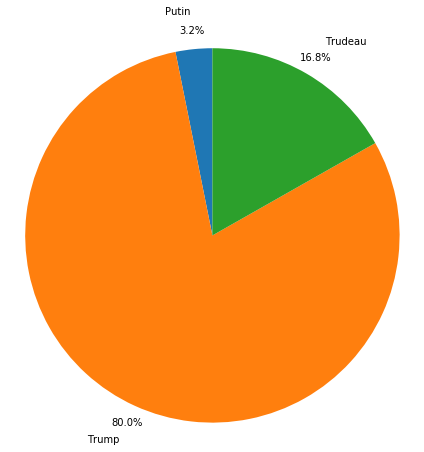

In [92]:
# Get the total number of occurance from the PUTIN column
putin_count = sample['PUTIN'].sum()

# Get the total number of occurance from the TRUMP column
trump_count = sample['TRUMP'].sum()

# Get the total number of occurance from the TRUDEAU column
trudeau_count = sample['TRUDEAU'].sum()

# Define labels
labels = 'Putin', 'Trump', 'Trudeau'

# Define the data
sizes = [putin_count, trump_count, trudeau_count]

# Plot Pie Chart
fig1, ax1 = plt.subplots(figsize = (6, 6))

# Pie Chart settings
ax1.pie(sizes, 
        labels = labels, 
        autopct = '%1.1f%%', 
        pctdistance = 1.1, 
        labeldistance=1.2, 
        startangle = 90)

# Makes the Pie Chart round
ax1.axis('equal')

# Plot settings
plt.tight_layout()

plt.show()

#### Interpretation of the Plot

As shown above, Trump is the most famous president. Trump's name was mentioned 329 times.

Note, the name Trump Jr. did not provide a biased result, since I made sure to check for this edge case and not include it in the total count.

### Which Country Makes it into the News Most Often?

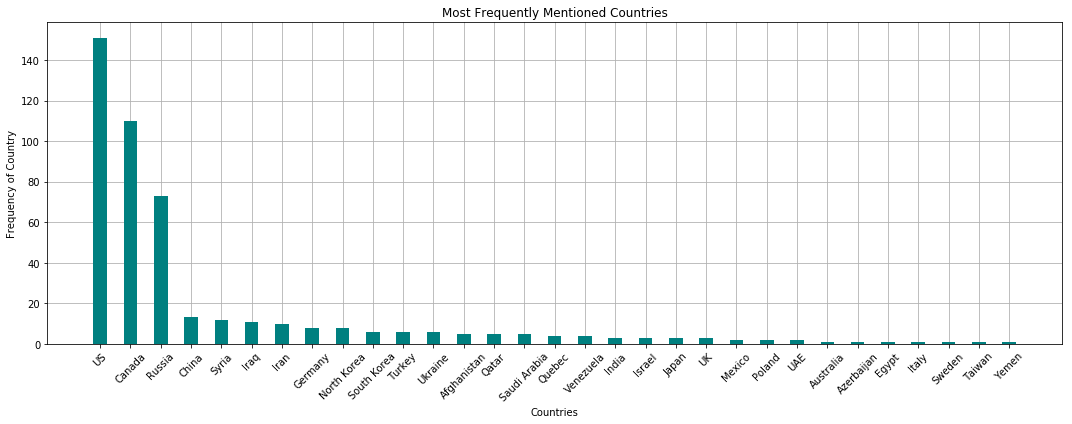

In [115]:
from operator import itemgetter

countries = [["Afghanistan", 5], ["Australia", 1], ["Azerbaijan", 1], ["Canada", 110], ["China", 13], ["Egypt", 1], ["Germany", 8], ["India", 3], ["Iran", 10], ["Iraq", 11], ["Israel", 3], ["Italy", 1], ["Japan", 3], ["South Korea", 6], ["Mexico", 2], ["North Korea", 8], ["Poland", 2], ["Qatar", 5], ["Quebec", 4], ["Russia", 73], ["Saudi Arabia", 5], ["Syria", 12], ["Sweden", 1], ["Taiwan", 1], ["Turkey", 6], ["UAE", 2], ["UK", 3], ["US", 151], ["Ukraine", 6], ["Venezuela", 4], ["Yemen", 1]]
countries = sorted(countries, key = itemgetter(1), reverse = True)

# Create the x and y-axis lists
y = []
x = []

# Create the labels list
labels = []

counter = 1

# Fill the x and y-axis list with data
# Fill the labels list with names of countries
for country in countries:
        
    x.append(counter)
    counter += 1
    
    y.append(country[1])
    labels.append(country[0])

# Plot Bar Chart
fig1, ax1 = plt.subplots(figsize = (15, 6))

# Bar Chart settings
ax1.bar(x, y, zorder = 3, width = 0.45, color = 'teal')

# Define the tricks on the x-axis to be the country names
plt.xticks(x, labels, rotation = 45)

# Define labels
plt.title('Most Frequently Mentioned Countries')
plt.xlabel('Countries')
plt.ylabel('Frequency of Country')

# Plot settings
plt.tight_layout()
plt.grid(zorder = 0)

plt.show()

#### Interpretation of the Plot

As shown above, US, Canada, and Russia are the top three countries that make it into the news most often. However, the results may be biased, since the three news publishers used, were from those countries.

## Conclusion